# Deep Learning for Kyoto dataset


In [2]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows",100)
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import metrics as me

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Positive", "\n False Negative \n Type II Error"],
             ["\n False Positive \n Type I Error", "\n True Negative"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, output_columns_2labels, normalize = False)
    #print("F1 Score: {}".format(me.f1_score(actual_value, pred_value)))

In [5]:
def get_count(pred_value):
    difficulty = pd.DataFrame({"Actual":actual_value, "Predict":pred_value, "difficulty_level":kdd_diff_level_test})
    #difficulty = pd.concat(difficulty, pd.Data)
    difficulty['accuracy'] = None
    difficulty.ix[difficulty.Actual == difficulty.Predict, "accuracy"] = 'Correct'
    difficulty.ix[difficulty.Actual != difficulty.Predict, "accuracy"] = 'Incorrect'
    diff_group = difficulty.loc[:,["difficulty_level", "accuracy", "Predict"]].groupby(["difficulty_level", "accuracy"])
    total_correct = sum(difficulty.Actual == difficulty.Predict)
    total_records = difficulty.shape[0]
    total_incorrect = total_records - total_correct
    print("Total Records:{}".format(total_records))
    return diff_group.count()

In [12]:
scores = pd.read_pickle("dataset/{}tf_vae_dense_trained_together_nsl_kdd_scores.pkl".format(master))
accumulate_test_scores = scores.iloc[:,0:3]
accumulate_test_time = scores.iloc[:,0:3]
#accumulate_test_scores

In [13]:
def evaluate(pred_pkl, past_pkl, actual_value, name = 'DNN'):
    global accumulate_test_scores
    global accumulate_test_time
    print(name)
    predictions = pd.read_pickle(pred_pkl)
    past = pd.read_pickle(past_pkl)
    
    df_sorted = past.reset_index().sort_values("test_score", ascending=False).iloc[0,0:3]
    epoch = int(df_sorted['epoch'])
    n_o_f = int(df_sorted['no_of_features'])
    h_l = int(df_sorted['hidden_layers'])
    print("Best model choosen is: Number of Features:{} Hidden Layers:{}".format(n_o_f,h_l))
    
    import fnmatch
    pred_keys = predictions.keys()
    best_hp = fnmatch.filter(pred_keys.tolist(), "*_{}_{}".format(n_o_f,h_l))
    
    df_pred = predictions[best_hp[0]] #.round(2)
    Attack_index = actual_value == 0
    Normal_index = actual_value == 1

    pred_value = df_pred["Prediction"] #np.argmax(df_pred.values, axis=1)
    plot(pred_value)
    
    gp = past.loc[n_o_f, h_l].groupby(by='epoch')
    mean = gp.test_score.max().mean()
    std = gp.test_score.max().std()
    N = gp.test_score.max().count()
    print("F1 Score: {}".format(me.f1_score(actual_value, pred_value)))
    print("Total Attack: {}, Total Normal: {}".format(sum(actual_value), len(actual_value) - sum(actual_value)))
    print("Mean: {}, std: {}, 95% conf int: {}".format(mean, std, stats.norm.interval(0.95, loc=mean, scale=std)))
    
    #return scores.sort_values("test_score", ascending=False)

In [14]:
def evaluate_scores(past_pkl, name = 'DNN'):

    print(name)
    past = pd.read_pickle(past_pkl)
    
    df_sorted = past.reset_index().sort_values("test_score", ascending=False).iloc[0,0:3]
    epoch = int(df_sorted['epoch'])
    n_o_f = int(df_sorted['no_of_features'])
    h_l = int(df_sorted['hidden_layers'])
    
    print("Best model choosen is: Number of Features:{} Hidden Layers:{}".format(n_o_f,h_l))
    
    gp = past.loc[n_o_f, h_l].groupby(by='epoch')
    mean = gp.test_score.max().mean()
    std = gp.test_score.max().std()
    N = gp.test_score.max().count()
    #print("Mean: {}, std: {}, 95% conf int: {}".format(mean, std, stats.norm.interval(0.95, loc=mean, scale=std)))
    
    disp = past.groupby(by=['no_of_features']).max().sort_values("test_score", ascending=False)
    return disp

# Evaluating Dense Network

![Fully Connected Network](images/NSL_KDD_FullyConnectedNetwork.jpg)

We used Fully connected Neural Network to observe the behavior of model training on NSL KDD data under various hyper parameter configurations as stated below:

- Feature Reduction  
We tried to reduce the number of features to understand how much the data can be compressed while still able to generalize enough for test dataset.
    
- Number of Hidden layers  
    We wanted to observe how many layers of dense networks may be required to capture the non-leanarity of the data. This understanding may prove useful while training other deep learning architectures.
- Epochs, learning rate   
    We wanted to get an understanding of how much time/resources will be required to train the model.

Dense Network Conf Matrix ++
Best model choosen is: Number of Features:32 Hidden Layers:1
F1 Score: 0.7920574644278722
Total Attack: 12833, Total Normal: 9711
Mean: 0.8608055412769318, std: 0.03687656820881274, 95% conf int: (0.78852879571422407, 0.93308228683963945)


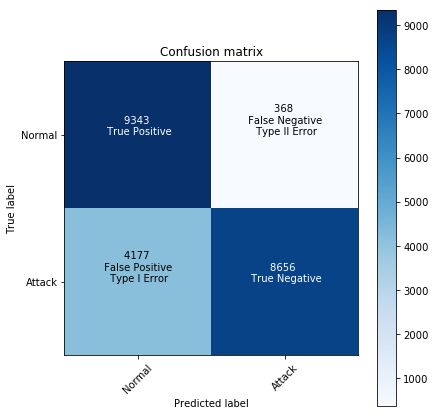

In [15]:
evaluate("dataset/{}tf_dense_only_nsl_kdd_predictions.pkl".format(master),
         "dataset/{}tf_dense_only_nsl_kdd_scores_all.pkl".format(master), actual_value, "Dense Network Conf Matrix ++")

Dense Network Conf Matrix +-
Best model choosen is: Number of Features:32 Hidden Layers:1
F1 Score: 0.7920574644278722
Total Attack: 12833, Total Normal: 9711
Mean: 0.8608055412769318, std: 0.03687656820881274, 95% conf int: (0.78852879571422407, 0.93308228683963945)


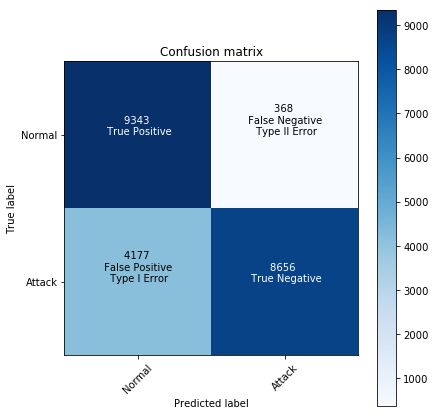

In [16]:
evaluate("dataset/{}tf_dense_only_nsl_kdd_predictions.pkl".format(master),
         "dataset/{}tf_dense_only_nsl_kdd_scores_all.pkl".format(master), actual_value, "Dense Network Conf Matrix +-")

In [17]:
evaluate_scores("dataset/{}tf_dense_only_nsl_kdd_scores_all.pkl".format(master), "Dense Network Scores")

Dense Network Scores
Best model choosen is: Number of Features:32 Hidden Layers:1


,epoch,train_score,test_score,test_score_20,time_taken
no_of_features,,,,,
32,33,0.965471,0.902191,0.829367,74.239607
122,11,0.965471,0.901348,0.852911,27.836271
8,33,0.968249,0.891412,0.843460,54.562763
1,33,0.963248,0.877928,0.791730,43.407795


In [18]:
evaluate("dataset/{}tf_dense_only_nsl_kdd_predictions__.pkl".format(master), "Dense Network +-")

TypeError: evaluate() missing 1 required positional argument: 'actual_value'

# Variational Autoencoders 

Variational Autoencoders can reduce the features by initially compressing the data and then calculating mean and variance of the compressed data features. Mean and variance is used to approximate data distribution (Z) of each compressed feature. The model learns by optimzing loss occured while reproducing the actual data using the Z data distribution.  

## Predict using Softmax
In order to predict whether current network session is Normal or Attack, we coupled Softmax with layer producing Z data distribution.

![VAE with Softmax](images/VAE_withSoftmax.jpg)


In [ ]:
evaluate("dataset/{}tf_vae_dense_trained_together_nsl_kdd_predictions.pkl".format(master),
         "dataset/{}tf_vae_dense_trained_together_nsl_kdd_scores.pkl".format(master), "VAE with Softmax")

## Include dependent Variable as feature.

Another approach we took is to train VAE to reproduce Normal/Attack labels itself during Training cylce. While testing, we would replace the labels with **random values(0~1)** and use VAE to generate correct values of the labels.

![VAE with Softmax](images/VAE_withLabel.jpg)


## using VAE Loss

< explain the variation >

In [ ]:
evaluate("dataset/{}tf_vae_only_vae_loss_nsl_kdd_predictions.pkl".format(master),
         "dataset/{}tf_vae_only_vae_loss_nsl_kdd_scores.pkl".format(master), "VAE with label (using VAE loss)")

## Using MSE Loss

In [ ]:
evaluate("dataset/{}tf_vae_only_nsl_kdd_predictions.pkl".format(master),
         "dataset/{}tf_vae_only_nsl_kdd_scores.pkl".format(master), "VAE with label (using MSE loss)")

# LSTM Autoencoder Model

LSTM Autoencoder, aka Seq2Seq, model is generally used to predict sequences of numbers (time dependent) given another sequence of numbers. LSTM encoders generates a context vector using input sequence which is passed on to decoder to generate the output.  
We coupled LSTM decoder cells with Softmax layer to generate probability whether current session is Normal or Attack  


![LSTM Encoder Decoder Model](images/LSTMseq2seq_withsoftmax.jpg)

In [ ]:
evaluate("dataset/{}tf_lstm_nsl_kdd_predictions.pkl".format(master),
         "dataset/{}tf_lstm_nsl_kdd_scores.pkl".format(master), "LSTM Autoencoder (Seq2Seq)")

In [ ]:
evaluate("dataset/{}tf_lstm_nsl_kdd_predictions-.pkl".format(master),
         "dataset/{}tf_lstm_nsl_kdd_scores-.pkl".format(master), "LSTM Autoencoder (Seq2Seq) 20% Data")

# Generative Adversarial Networks

## General Concept

GANs utilizes two networks, Generator and Discriminator, to learn about data distribution by generating the data itself.
- Generator Network is responsible to produce data of interest using random values.
- Discriminator Network is responsible to identify between fake data produced by Generator and Actual sample of data.

The optimized state of GANs is when Generator starts to produce enough realistic data so discriminator cannot distinguish between real data and generated data



![Generative Advarsarial Networks](images/NSL_KDD_GAN_original_idea.jpg)

## GANs - For Hypothesis testing

We suggest a learning model where GANs can be used for Hypothesis testing. Assume we have 2 data distributions D1 and D2:
- Generator will be responsible to produce D2 distribution using random values
- Discriminiator will be responsible to distinguish between D1 and D2 distributions.  

Basically, discriminator will output probability between 0~1 whether current data is D1 or not. In this way we can decide a significance level based on which it can be decided to either Accept or Reject Null hypothesis i.e. whether current data is D1 or not.

![GAN_hypo_optim_state](images/NSL_KDD_GAN_initial_state.jpg)
![GAN_hypo_optim_state](images/NSL_KDD_GAN_hypo_optim_state.jpg)

### GANs for NSL KDD dataset 



![GANs for NSL KDD dataset ](images/NSL_KDD_GAN_attack_hypothesis.jpg)

# Compare Results

In [ ]:
#accumulate_test_scores['param'] = accumulate_test_scores[['epoch','no_of_features', 'hidden_layers']].apply(lambda x : 'epoch:{}_features:{}_layers:{}'.format(x[0],x[1], x[2]), axis=1)
accumulate_test_scores['Scenarios'] = accumulate_test_scores[['no_of_features', 'hidden_layers']].apply(lambda x : 'features:{}_layers:{}'.format(x[0], x[1]), axis=1)
accumulate_test_time['Scenarios'] = accumulate_test_time[['no_of_features', 'hidden_layers']].apply(lambda x : 'features:{}_layers:{}'.format(x[0], x[1]), axis=1)


In [ ]:
accumulate_test_scores = accumulate_test_scores.drop(['epoch','no_of_features', 'hidden_layers'], axis = 1)
accumulate_test_time = accumulate_test_time.drop(['epoch','no_of_features', 'hidden_layers'], axis = 1)

In [ ]:
accumulate_test_scores.set_index("Scenarios", inplace = True)
accumulate_test_time.set_index("Scenarios", inplace = True)

In [ ]:
accumulate_test_scores.replace(np.nan, '<Not Tested>', regex=True)

In [ ]:
f = plt.figure()
accumulate_test_scores.plot(kind='bar', figsize=(15,4), ax=f.gca(),grid=True, )
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Test Accuracy")
plt.show()

In [ ]:
accumulate_test_scores.to_csv("dataset/{}scores.csv".format(master))

In [ ]:
accumulate_test_time.replace(np.nan, '<Not Tested>', regex=True)

In [ ]:
f = plt.figure()
accumulate_test_time.plot(kind='bar', figsize=(15,4), ax=f.gca(),grid=True, )
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Time required for Training (in secs)')
plt.show()

In [ ]:
accumulate_test_time.to_csv("dataset/{}time.csv".format(master))